<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Solution-for-exercise:-Experiments-with-CNNs" data-toc-modified-id="Solution-for-exercise:-Experiments-with-CNNs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Solution for exercise: Experiments with CNNs</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Class-for-providing-images" data-toc-modified-id="Class-for-providing-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Class for providing images</a></span></li><li><span><a href="#Function-for-building-a-CNN-(using-Keras)" data-toc-modified-id="Function-for-building-a-CNN-(using-Keras)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function for building a CNN (using Keras)</a></span></li><li><span><a href="#Function-for-training-a-CNN" data-toc-modified-id="Function-for-training-a-CNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Function for training a CNN</a></span></li><li><span><a href="#Function-for-testing-a-CNN-model" data-toc-modified-id="Function-for-testing-a-CNN-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Function for testing a CNN model</a></span></li><li><span><a href="#Experiment:-Sensitivity-of-start-weights" data-toc-modified-id="Experiment:-Sensitivity-of-start-weights-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Experiment: Sensitivity of start weights</a></span></li><li><span><a href="#Experiment:-Influence-of-training-dataset-size" data-toc-modified-id="Experiment:-Influence-of-training-dataset-size-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Experiment: Influence of training dataset size</a></span></li></ul></div>

# Solution for exercise: Experiments with CNNs

Prepare a folder data with the following structure:

    data
        train
            car
            bike
        test
            car
            bike
            
and store at least some
- hundreds-1000 of images for each object category in the training subfolders
- some hundreds of images for each object category in the test subfolders


# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Using TensorFlow backend.


Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Class for providing images

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [2]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder,
                 nr_imgs_per_class_to_use):
        
        # 1. The result of the image scan will be stored
        #    in this list
        self.all_training_items = []
       
    
        # 2. Get a list of all subfolders =
        #    a list of all image classes        
        self.class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]
        
        #print("Under folder\n\t", root_folder,
        #      "\nI found the following subfolders/classes:")
        #print(self.class_names)
    
    
        # 3. How many classes are there?
        self.nr_classes = len(self.class_names)
    
    
        # 4. For each subfolder ...
        total_nr_imgs_in_principle_available = 0
        for class_id, class_name in enumerate(self.class_names):
            
            # 4.1 Compute absolute folder name
            subfolder_name = root_folder + "/" + class_name + "/"
            
            # 4.2 Get list of image files in that class image folder
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name)
                 if isfile(join(subfolder_name, f))]
            
            #print("{} files in subfolder {}".format(len(filenames),
            #                                        subfolder_name) )
            
            # 4.3 How many images to get from that folder?
            nr_files_available = len(filenames)
            total_nr_imgs_in_principle_available += nr_files_available
            nr_files_to_store = min(nr_files_available,
                                    nr_imgs_per_class_to_use)
            
            # 4.4 For each image filename in current subfolder ...
            for file_nr in range(0,nr_files_to_store):
                
                # get next filename
                filename = filenames[file_nr]
                
                # prepare a one-hot encoded class teacher vector
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                # store "training item" which is mainly
                # the information of the image filename
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        
        # 5. Show how many images are in principle available
        #    and how many we "extracted" 
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available."
              .format(total_nr_imgs_in_principle_available))
        print("Since I only should extract {} images "
              "per class, I stored in total (only) {} image files."
              .format(nr_imgs_per_class_to_use, self.nr_images))        
        
        #print("Here are the first 3 entries of the training items list generated:")
        #print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [3]:
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
nr_images_to_retrieve_per_class = 10
train_img_provider = image_provider( train_folder,
                                     nr_images_to_retrieve_per_class)

There are 2000 images in total available.
Since I only should extract 10 images per class, I stored in total (only) 20 image files.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [1. 0.]


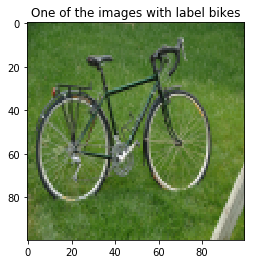

In [4]:
image, class_id, class_name, teacher_vec = \
    train_img_provider.get_random_image()
    
THE_INPUT_IMG_SHAPE = image.shape
    
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Function for building a CNN (using Keras)

In [5]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras import backend as K

def build_cnn_model(input_shape_of_single_image, nr_output_neurons):
    
    
    # clear the last Keras session
    # this will clear the underlying TensorFlow graph
    K.clear_session()

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 4
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))
    
    
    # 3. Show the model
    model.summary()


    # 4. Build model and configure model for training
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

# end build_a_cnn_model

# Function for training a CNN

In [6]:
import time

def train_cnn(your_cnn, train_img_provider, nr_train_steps):
    
    train_time_start = time.time()
    
    height      = THE_INPUT_IMG_SHAPE[0]
    width       = THE_INPUT_IMG_SHAPE[1]
    nr_channels = THE_INPUT_IMG_SHAPE[2]

    X = np.zeros( (1,height,width,nr_channels)     )
    Y = np.zeros( (1,train_img_provider.nr_classes) )

    print("Steps to train: {}".format(nr_train_steps))
    
    for train_step in range(0,nr_train_steps):

        if train_step % 500 == 0:
            print("training step ", train_step)

        # 1. get the next random image from the dataset
        image, class_id, class_name, teacher_vec = \
            train_img_provider.get_random_image()

        # 2. put the image into a 4D array
        #    note: Keras expects a 4D array as input for
        #          the training function fit()
        X[0,:,:,:] = image

        # 3. the teacher value array expected by Keras
        #    is a 2D array
        Y[0,:] = teacher_vec


        # 3. train the model using this image    
        my_cnn.fit(X,Y,verbose=0)        
    
    train_time_end = time.time()
    print("Training finished!")    
            
    train_duration_sec = train_time_end - train_time_start
    print("Training time: {:.2f} sec = {:.2f} min"
          .format(train_duration_sec,
                  train_duration_sec/60)
          )
                  


# Function for testing a CNN model

In [7]:
def test_cnn(your_cnn,
             test_img_provider,
             show_example_predictions):
    
    nr_test_images = test_img_provider.nr_images
    
    correct_classified = 0
    
    print("I will test the CNN on {} test images".
          format(nr_test_images))
    
    for test_img_nr in range(0, nr_test_images):
        
        if test_img_nr % 100 == 0:
            print("Tested {} images so far".
                  format(test_img_nr))
        
        # 1. 
        # get the next test image from the
        # test image provider
        img, gt_class_nr, class_label, teacher_vec = \
            test_img_provider.get_specific_image( test_img_nr )
    
        
        # 2.
        # reshape image (3D array) to a 4D array
        # since Keras wants 4D arrays as input
        X = img.reshape((-1,
                         img.shape[0],
                         img.shape[1],
                         img.shape[2]
                        )
                       )
        
        # 3.
        # let the CNN predict the image class
        neuron_outputs = your_cnn.predict(X)
        
        # 4.
        # determine the predicted class nr
        predicted_class_nr = np.argmax(neuron_outputs.reshape(-1))
        
        # 5.
        # Did the CNN correctly predict the class?
        if predicted_class_nr == gt_class_nr:
            correct_classified +=1
        prediced_class_label = \
            test_img_provider.class_names[predicted_class_nr]
            
        # 6.
        # Show image, predicted class and gt class?
        if show_example_predictions and np.random.randint(50)==0:
                        
            plt.title("Is: {} vs. Predicted: {}\nNeuron out: {}"
                      .format(class_label,
                              prediced_class_label,
                              neuron_outputs
                             )
                     )
            plt.imshow( img )
            plt.show()
            
        
    # finally, compute the correct classification rate
    corr_classification_rate = \
        float(correct_classified) / float(nr_test_images)
        
    print("Correctly classified: {} of {} images:"
          " --> rate: {:.2f}"
          .format(correct_classified,
                  nr_test_images,
                  corr_classification_rate)
         )   
    
    # return the correct classification rate
    return corr_classification_rate
    
    

# Experiment: Sensitivity of start weights

In [20]:
NR_MODELS_TO_TEST = 10

# 1. prepare a train image provider
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
nr_images_to_retrieve_per_class = 10000
train_img_provider = image_provider( train_folder,
                                     nr_images_to_retrieve_per_class)

# 2. prepare a test image provider
test_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test"
test_img_provider = image_provider( test_folder,
                                    nr_images_to_retrieve_per_class)

# 3. for all CNN models to generate...
model_ids = []
classification_rates = []
for model_nr in range(0,NR_MODELS_TO_TEST):
    
    print("\n\n")
    print("**************")
    print("Model nr:", model_nr)
    print("**************")
    print("\n")

    # 3.1 create a new CNN model
    
    #tf.set_random_seed(12345)
    np.random.seed(0)
    my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE,
                             train_img_provider.nr_classes)

    # 3.2 train the CNN model
    train_cnn(my_cnn, train_img_provider, 100)

    # 3.3 test the model
    show_example_predictions = False
    corr_class_rate = test_cnn(my_cnn,
                               test_img_provider,
                               show_example_predictions)
    
    # 3.4 store classification rate
    model_ids.append( model_nr )
    classification_rates.append( corr_class_rate )


There are 2000 images in total available.
Since I only should extract 10000 images per class, I stored in total (only) 2000 image files.
There are 651 images in total available.
Since I only should extract 10000 images per class, I stored in total (only) 651 image files.



**************
Model nr: 0
**************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
Total params: 38,434
Trainable params: 38,434
Non-trainable params: 0
_________________

KeyboardInterrupt: 

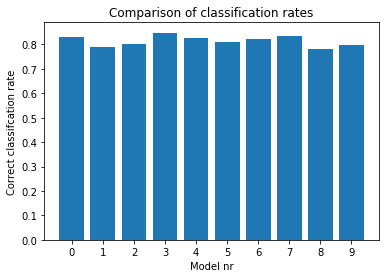

Minimum rate: 0.7818740399385561
Maximum rate: 0.847926267281106
Range in percent: 6.60522273425499

 [0.8294930875576036, 0.7910906298003072, 0.8033794162826421, 0.847926267281106, 0.8279569892473119, 0.8079877112135176, 0.8233486943164362, 0.8341013824884793, 0.7818740399385561, 0.7987711213517665]


In [16]:
# Show comparison of different models as bar diagram
plt.xticks(model_ids)
plt.bar(model_ids, classification_rates)
plt.title("Comparison of classification rates")
plt.xlabel("Model nr")
plt.ylabel("Correct classifcation rate")
plt.show()

min_rate = min(classification_rates)
max_rate = max(classification_rates)

print("Minimum rate:", min_rate)
print("Maximum rate:", max_rate)
print("Range in percent:", (max_rate-min_rate)*100.0)

print("\n",classification_rates)

**Conclusion: The random start initialization has a large impact on the final correct classification rate of a CNN - when the number of training steps is fixed.**

# Experiment: Influence of training dataset size

In [ ]:
# 1. prepare a test image provider
test_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test"
test_img_provider = image_provider( test_folder,
                                    nr_images_to_retrieve_per_class)

# 2. for all CNN models to generate...
train_dataset_sizes = []
classification_rates = []
STEP_SIZE = 100
for nr_train_imgs_per_class in range(STEP_SIZE,1000,STEP_SIZE):
    
    print("\n\n")
    print("*************************************")
    print("Nr of train images per class:", nr_train_imgs_per_class)
    print("*************************************")
    print("\n")
    
    # 2.1 prepare a train image provider
    #     that uses the specified number of train
    #     images per class
    train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"    
    train_img_provider = image_provider( train_folder,
                                         nr_train_imgs_per_class)


    # 2.2 create a new CNN model
    #     BUT (IMPORTANT!) ALWAYS
    #     START WITH THE SAME WEIGHTS
    #     IN ORDER TO MAKE THE INFLUENCE
    #     OF THE DATASET SIZE COMPARABLE
    #     else:
    #     the random start initialization
    #     of the weights have a too strong
    #     influence onto the final classification
    #     rate!
    np.random.seed(0)
    my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE,
                             train_img_provider.nr_classes)

    # 2.3 train the CNN model
    train_cnn(my_cnn, train_img_provider, 5000)

    # 2.4 test the model
    show_example_predictions = False
    corr_class_rate = test_cnn(my_cnn,
                               test_img_provider,
                               show_example_predictions)
    
    # 2.5 store classification rate
    train_dataset_sizes.append( nr_images_to_retrieve_per_class )
    classification_rates.append( corr_class_rate )

There are 651 images in total available.
Since I only should extract 10000 images per class, I stored in total (only) 651 image files.



*************************************
Nr of train images per class: 100
*************************************


There are 2000 images in total available.
Since I only should extract 100 images per class, I stored in total (only) 200 image files.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
Total params: 38,434
T

Tested 200 images so far
Tested 300 images so far
Tested 400 images so far
Tested 500 images so far
Tested 600 images so far
Correctly classified: 540 of 651 images: --> rate: 0.83



*************************************
Nr of train images per class: 600
*************************************


There are 2000 images in total available.
Since I only should extract 600 images per class, I stored in total (only) 1200 image files.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)   

In [ ]:
# Show comparison of different models as bar diagram
plt.xticks(train_dataset_sizes)
plt.bar(train_dataset_sizes, classification_rates)
plt.title("Comparison of classification rates")
plt.xlabel("Nr of training images per class")
plt.ylabel("Correct classifcation rate")
plt.show()

min_rate = min(classification_rates)
max_rate = max(classification_rates)

print("Minimum rate:", min_rate)
print("Maximum rate:", max_rate)
print("Range in percent:", (max_rate-min_rate)*100.0)

print("\n",classification_rates)